In [2]:
!pip install prophet --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
import os


In [3]:
BASE_PATH = "/content/Milestone3"
DATA_PATH = f"{BASE_PATH}/data"
VIS_PATH = f"{BASE_PATH}/visualizations"

os.makedirs(VIS_PATH, exist_ok=True)


In [4]:
hr_df = pd.read_csv(f"{DATA_PATH}/heartrate_seconds_merged.csv")
sleep_df = pd.read_csv(f"{DATA_PATH}/sleepDay_merged.csv")

hr_df['Time'] = pd.to_datetime(hr_df['Time'])
sleep_df['SleepDay'] = pd.to_datetime(
    sleep_df['SleepDay'],
    format='%m/%d/%Y %I:%M:%S %p'
)


In [5]:
user_ids = hr_df['Id'].unique()[:5]
print("Selected Users:", user_ids)


Selected Users: [2022484408 2026352035 2347167796 4020332650 4558609924]


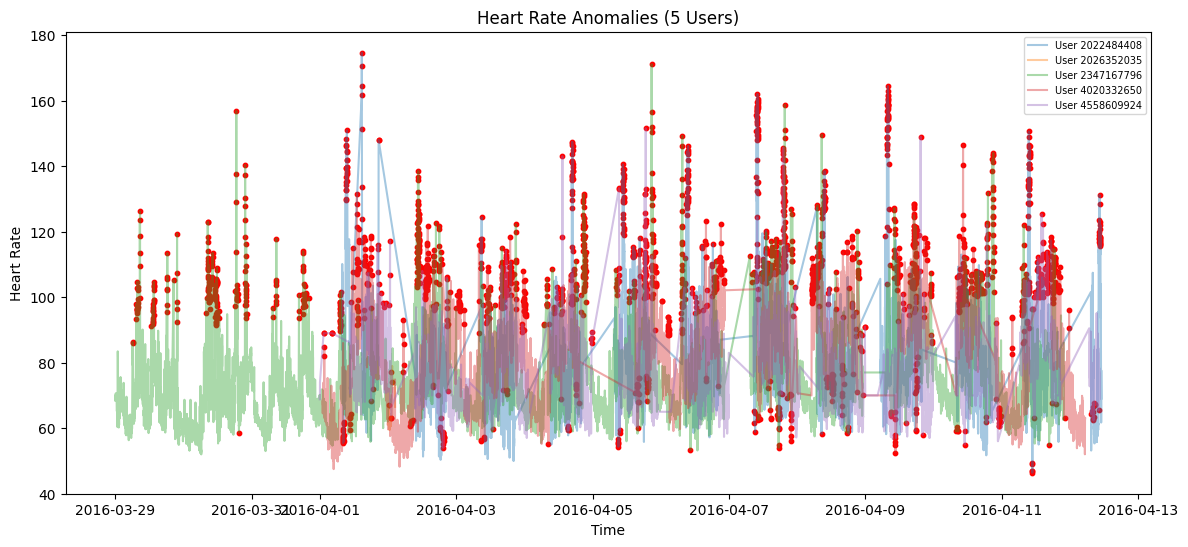

In [6]:
plt.figure(figsize=(14,6))

for uid in user_ids:
    user_hr = hr_df[hr_df['Id'] == uid].copy()

    user_hr = user_hr.rename(columns={'Time': 'ds', 'Value': 'y'})
    user_hr = user_hr[['ds','y']].sort_values('ds')

    user_hr = (
        user_hr
        .set_index('ds')
        .resample('1min')
        .mean()
        .dropna()
        .reset_index()
    )

    model = Prophet(
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=True
    )
    model.fit(user_hr)

    forecast = model.predict(user_hr[['ds']])
    user_hr['residual'] = user_hr['y'] - forecast['yhat']

    threshold = 2 * user_hr['residual'].std()
    anomalies = user_hr[abs(user_hr['residual']) > threshold]

    plt.plot(user_hr['ds'], user_hr['y'], alpha=0.4, label=f'User {uid}')
    plt.scatter(anomalies['ds'], anomalies['y'], color='red', s=10)

plt.title("Heart Rate Anomalies (5 Users)")
plt.xlabel("Time")
plt.ylabel("Heart Rate")
plt.legend(fontsize=7)

plt.savefig(f"{VIS_PATH}/heart_rate_anomalies_5_users.png")
plt.show()


In [7]:
sleep_5 = sleep_df[sleep_df['Id'].isin(user_ids)].copy()
sleep_5 = sleep_5.sort_values("SleepDay")

sleep_5['anomaly'] = np.where(
    (sleep_5['TotalMinutesAsleep'] < 360) |
    (sleep_5['TotalMinutesAsleep'] > 600),
    'Anomaly',
    'Normal'
)


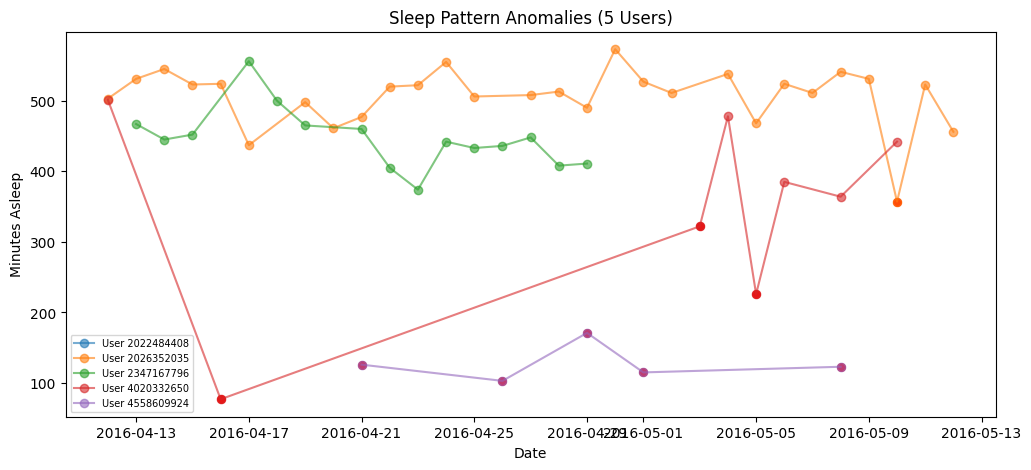

In [8]:
plt.figure(figsize=(12,5))

for uid in user_ids:
    user_sleep = sleep_5[sleep_5['Id'] == uid]

    plt.plot(
        user_sleep['SleepDay'],
        user_sleep['TotalMinutesAsleep'],
        marker='o',
        alpha=0.6,
        label=f'User {uid}'
    )

    anomalies = user_sleep[user_sleep['anomaly'] == 'Anomaly']
    plt.scatter(
        anomalies['SleepDay'],
        anomalies['TotalMinutesAsleep'],
        color='red',
        s=30
    )

plt.title("Sleep Pattern Anomalies (5 Users)")
plt.xlabel("Date")
plt.ylabel("Minutes Asleep")
plt.legend(fontsize=7)

plt.savefig(f"{VIS_PATH}/sleep_anomalies_5_users.png")
plt.show()
